In [1]:
%matplotlib inline
from numba import jit
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import time

from tqdm import tqdm_notebook as tqdm

plt.style.use("./plotting/matplotlibrc")


mpl.rcParams['figure.dpi'] = 92

textwidth = 5.5532

In [44]:
def sim_loop(nt,
             E_sequ,
             N=1000,
             cf=.1,
             W_gen = np.random.normal,
             sigm_w = 2.,
             cf_in=1.,
             w_in_gen = np.random.normal,
             sigm_w_in = 1.,
             eps_a = 0.005,
             eps_b = 0.001,
             eps_var_y = 0.004,
             eps_var_X = 0.004,
             eps_sigm_t = 0.005,
             mu_y_target_gen = np.random.normal,
             sigm_mu_y_target = 0.01):
    
    ### Initialization
    
    ## Recurrent Weights
    W =  W_gen(0.,sigm_w/(cf*N)**.5,(N,N))*(np.random.rand(N,N) <= cf)
    ## No self-connection
    W[range(N),range(N)] = 0.
    
    W_T_squ = W.T**2.
    
    ##  w_in
    w_in = w_in_gen(0.,sigm_w_in,(N))*(np.random.rand(N)<=cf_in)
    
    ### Generate Node Input
    E = np.outer(E_sequ,w_in)
    
    ### Targeted mean Activity
    mu_y_target = mu_y_target_gen(0.,sigm_mu_y_target,(N))
        
    
    y = np.zeros((nt,N))
    X = np.zeros((nt,N))
    
    # Init y in a random state
    y[0,:] = (np.random.rand(N)-.5)*2.
    
    
    X[0,:] = np.zeros(N)
    
    var_y = np.ones((nt,N))
    var_X = np.ones((nt,N))
    
    a = np.ones((nt,N))
    
    b = np.zeros((nt,N))
    
    #sigm_t = np.ones((nt))*0.25
    #sigm_t = np.random.random_sample((nt,N))*0.25
    sigm_t = np.random.lognormal(0.,1.,(nt,N))
    
    t_ax = np.arange(nt)
    
    v = np.ones((nt))
    
    for t in tqdm(range(1,nt)):
        
                
        X[t,:] = W.dot(y[t-1,:])
        
        y[t,:] = np.tanh(a[t-1,:]*(X[t,:] + E[t,:] - b[t-1,:]))
        
        var_y[t,:] = (1.-eps_var_y)*var_y[t-1,:] + eps_var_y*(y[t,:] - mu_y_target)**2.
        var_X[t,:] = var_X[t-1,:]*(1.-eps_var_X) + eps_var_X*(X[t,:])**2.
        
        sigm_y = var_y[t,:]**.5
        
        v[t] = (W_T_squ*a[t-1,:]**2.).mean()*N
        
        #sigm_t[t] = sigm_t[t-1] + eps_sigm_t*sigm_t[t-1]*(1.-v[t])
        sigm_t[t,:] = sigm_t[t-1,:] + eps_sigm_t*sigm_t[t-1,:]*(1.-v[t])
        
        a[t,:] = a[t-1,:] + eps_a * a[t-1,:]*(sigm_t[t] - sigm_y)
    
        b[t,:] = b[t-1,:] + eps_b * (y[t,:] - mu_y_target)
    
    return t_ax, y, X, var_y, var_X, a, b, W, w_in, mu_y_target,sigm_t,v

In [45]:
nt = 30000

# Input sequence Normal Distribution
E_sequ = np.random.normal(0.,1.,(nt))*.7

In [46]:
t_ax,y,X,vy,vX,a,b,W,w_in,mu_y_target,sigm_t,v = sim_loop(nt,E_sequ)

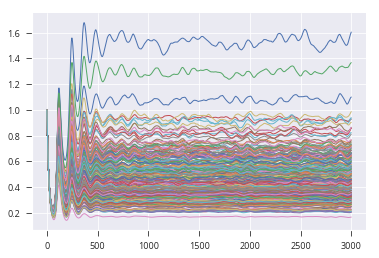

In [56]:
plt.plot(a[::10,:250])
plt.show()

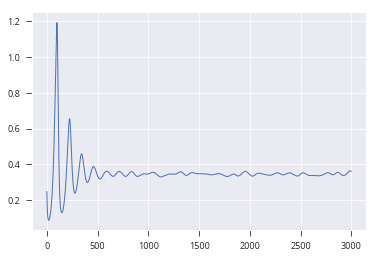

In [49]:
#plt.plot(sigm_t[::10,:150])
plt.plot(sigm_t[::10])
plt.show()

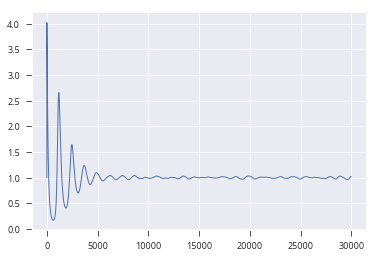

In [50]:
plt.plot(v)
plt.show()

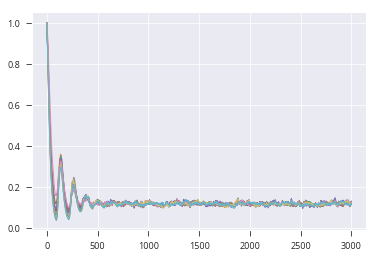

In [51]:
plt.plot(vy[::10,:10])
plt.show()

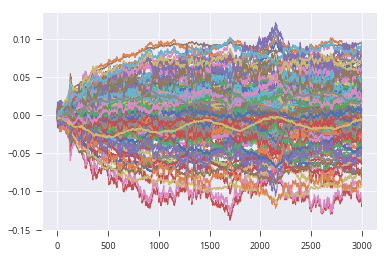

In [52]:
plt.plot(b[::10,:150])
plt.show()

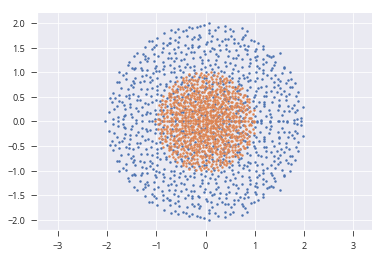

In [53]:
l1 = np.linalg.eigvals((W.T * a[0,:]).T)
l2 = np.linalg.eigvals((W.T * a[-1,:]).T)

plt.plot(l1.real,l1.imag,'.',markersize=5)
plt.plot(l2.real,l2.imag,'.',markersize=5)

plt.axis("equal")

plt.show()

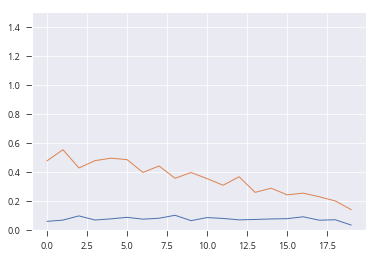

In [58]:
h1 = np.histogram(np.abs(l1),bins=20)
h2 = np.histogram(np.abs(l2),bins=20)

plt.plot(h1[0][:]/((h1[1][1:]**2.-h1[1][:-1]**2.)*np.pi*1000.))
plt.plot(h2[0][:]/((h2[1][1:]**2.-h2[1][:-1]**2.)*np.pi*1000.))

plt.ylim([0.,1.5])

plt.show()

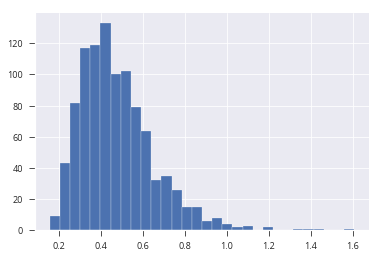

In [57]:
plt.hist(a[-1,:],bins=30)
plt.show()

/home/fschubert/work/py35/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


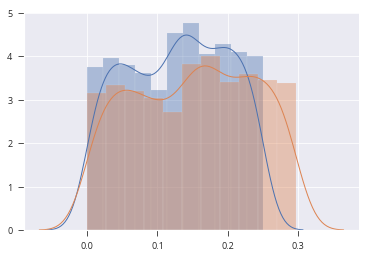

In [42]:
sns.distplot(sigm_t[0,:])
sns.distplot(sigm_t[-1,:])
plt.show()